# Reasoning without Observation

In [ReWOO](https://arxiv.org/abs/2305.18323), Xu, et. al, propose an agent that combines a multi-step planner and variable substitution for effective tool use. It was designed to improve on the ReACT-style agent architecture in the following ways:

1. Reduce token consumption and execution time by generating the full chain of tools used in a single pass. (_ReACT-style agent architecture requires many LLM calls with redundant prefixes (since the system prompt and previous steps are provided to the LLM for each reasoning step_)
2. Simplify the fine-tuning process. Since the planning data doesn't depend on the outputs of the tool, models can be fine-tuned without actually invoking the tools (in theory).


The following diagram outlines ReWOO's overall computation graph:

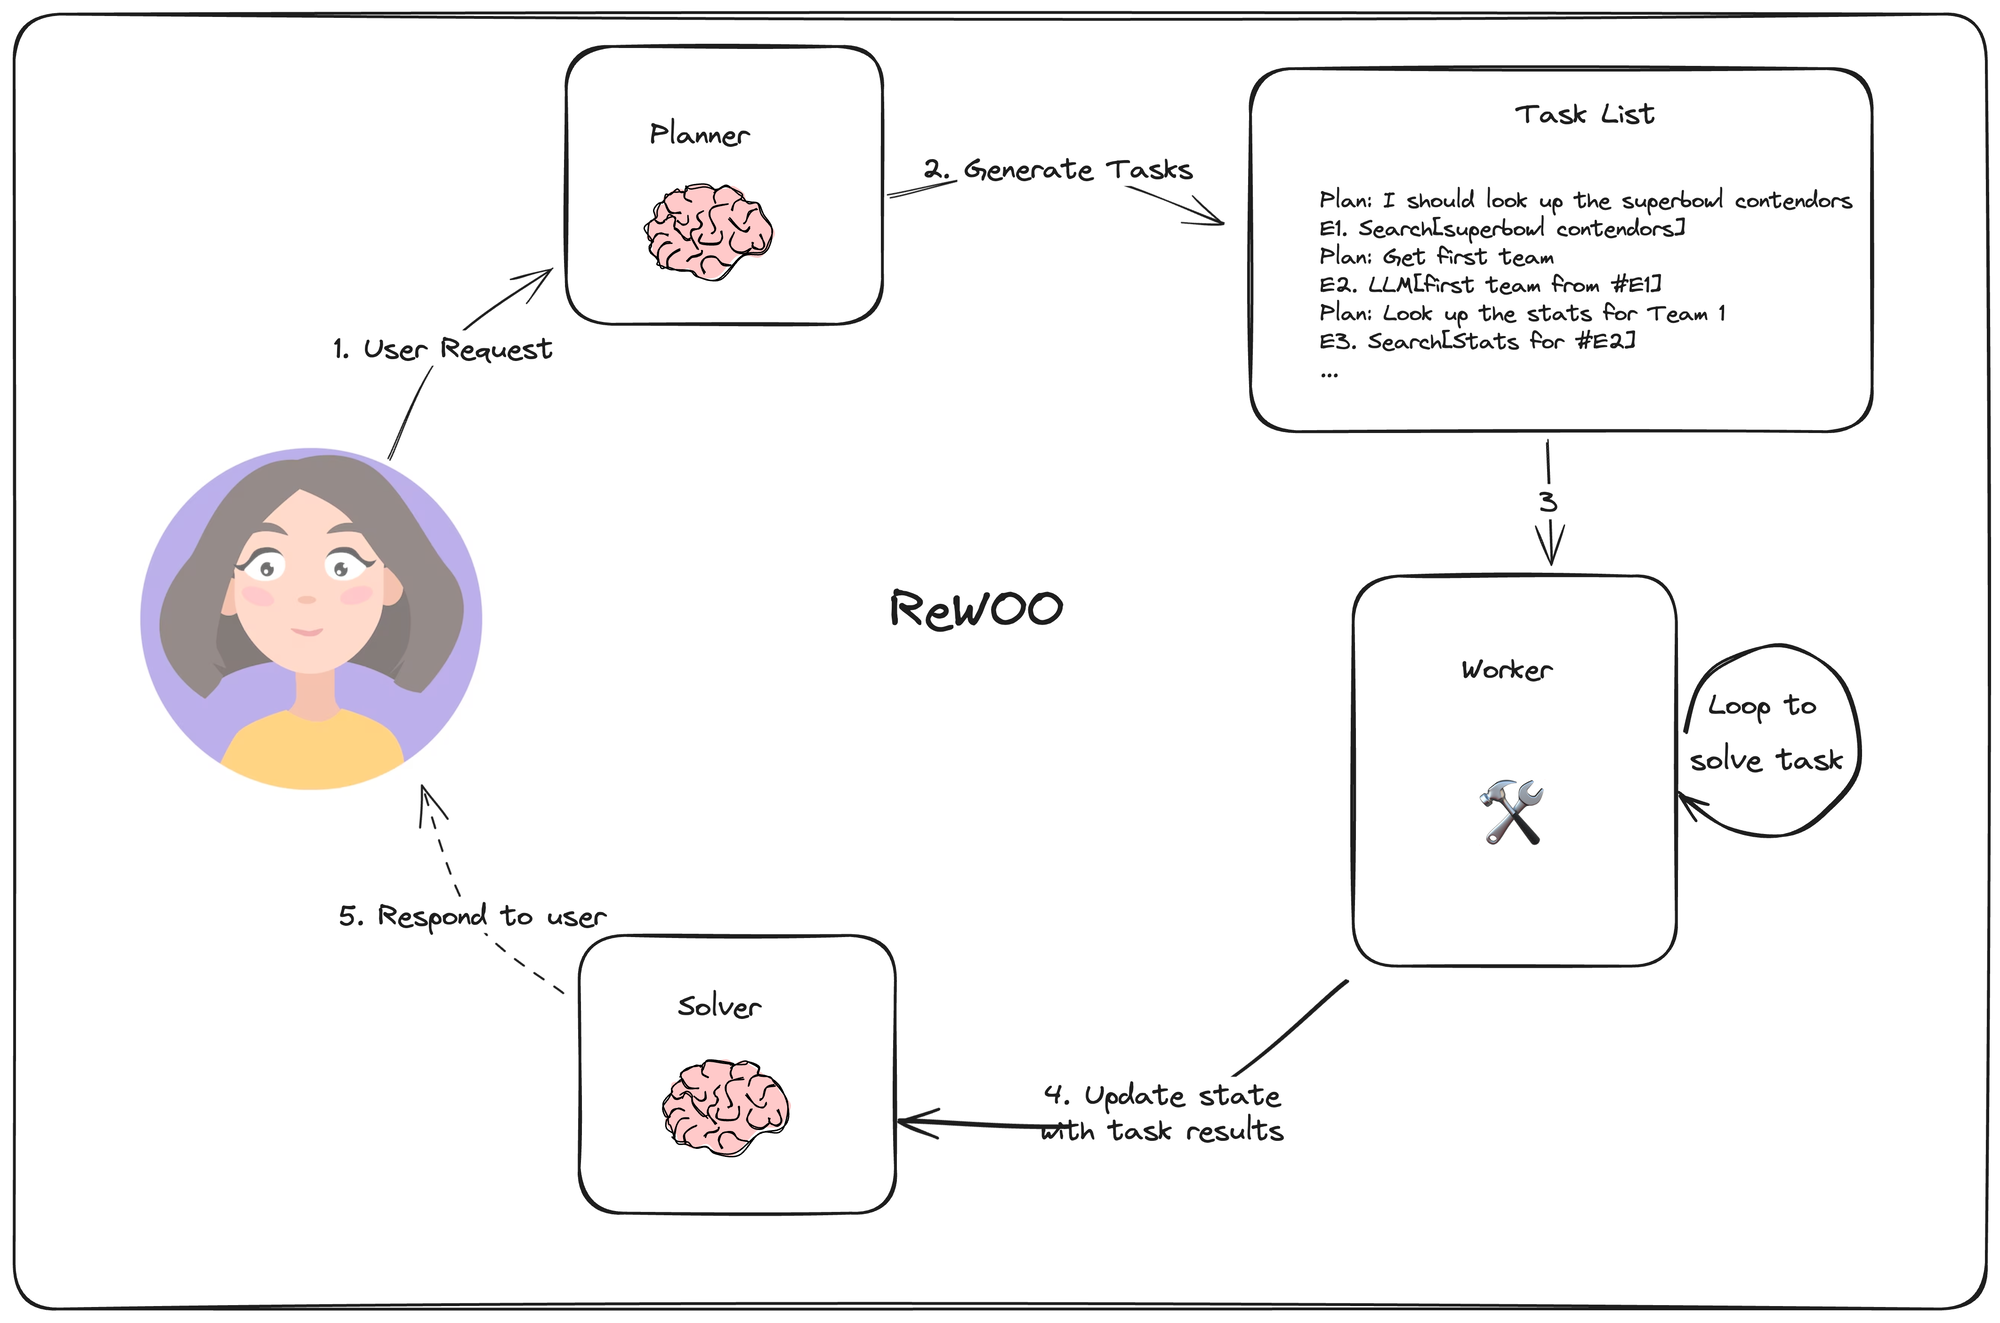

ReWOO is made of 3 modules:

1. 🧠**Planner**: Generate the plan in the following format:
```text
Plan: <reasoning>
#E1 = Tool[argument for tool]
Plan: <reasoning>
#E2 = Tool[argument for tool with #E1 variable substitution]
...
```
3. **Worker**: executes the tool with the provided arguments.
4. 🧠**Solver**: generates the answer for the initial task based on the tool observations.

The modules with a 🧠 emoji depend on an LLM call. Notice that we avoid redundant calls to the planner LLM by using variable substitution.

In this example, each module is represented by a LangGraph node. The end result will leave a trace that looks [like this one](https://smith.langchain.com/public/39dbdcf8-fbcc-4479-8e28-15377ca5e653/r). Let's get started!

## Setup

For this example, we will provide the agent with a Tavily search engine tool. You can get an API key [here](https://app.tavily.com/sign-in) or replace with a free tool option (e.g., [duck duck go search](https://python.langchain.com/v0.2/docs/integrations/tools/ddg/)).

Let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain_community langchain_openai tavily-python

In [2]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}=")


_set_if_undefined("TAVILY_API_KEY")
_set_if_undefined("OPENAI_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Define graph state

In LangGraph, every node updates a shared graph state. The state is the input to any node whenever it is invoked.

Below, we will define a state dict to contain the task, plan, steps, and other variables.

In [3]:
from typing import List, TypedDict


class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

## Planner

The planner prompts an LLM to generate a plan in the form of a task list. The arguments to each task are strings that may contain special variables (`#E{0-9}+`) that are used for variable substitution from other task results.

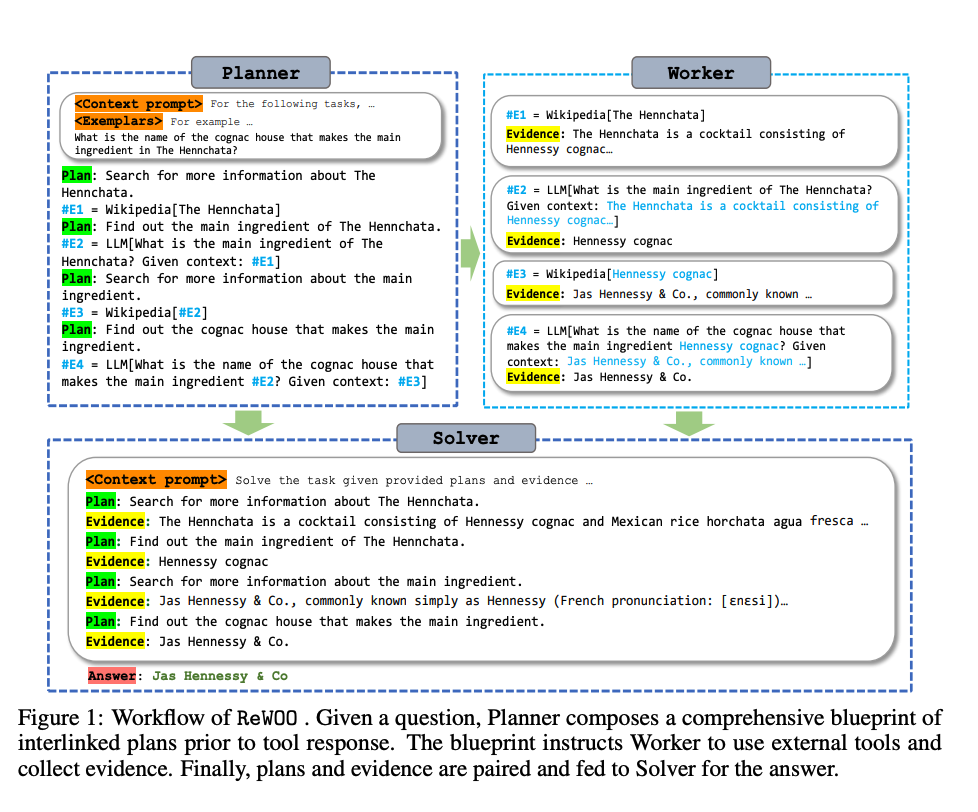

Our example agent will have two tools: 
1. Google - a search engine (in this case Tavily)
2. LLM - an LLM call to reason about previous outputs.

The LLM tool receives less of the prompt context and so can be more token-efficient than the ReACT paradigm.

In [4]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)

In [5]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) Google[input]: Worker that searches results from Google. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha. #E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked. #E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked. #E3 = Calculator[(2 ∗ #E2 − 10) − 8]

Begin! 
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}"""

In [6]:
task = "what is the hometown of the 2024 australian open winner"

In [7]:
result = model.invoke(prompt.format(task=task))

In [8]:
print(result.content)

Plan: Use Google to search for the 2024 Australian Open winner.
#E1 = Google[2024 Australian Open winner]

Plan: Retrieve the name of the 2024 Australian Open winner from the search results.
#E2 = LLM[What is the name of the 2024 Australian Open winner, given #E1]

Plan: Use Google to search for the hometown of the 2024 Australian Open winner.
#E3 = Google[hometown of 2024 Australian Open winner, given #E2]

Plan: Retrieve the hometown of the 2024 Australian Open winner from the search results.
#E4 = LLM[What is the hometown of the 2024 Australian Open winner, given #E3]


#### Planner Node

To connect the planner to our graph, we will create a `get_plan` node that accepts the `ReWOO` state and returns with a state update for the
`steps` and `plan_string` fields.

In [11]:
import re

from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form E#... = ...[...]
regex_pattern = r"Plan:\s*(.+)\s*(#E\d+)\s*=\s*(\w+)\s*\[([^\]]+)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | model


def get_plan(state: ReWOO):
    task = state["task"]
    result = planner.invoke({"task": task})
    # Find all matches in the sample text
    matches = re.findall(regex_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}

## Executor

The executor receives the plan and executes the tools in sequence.

Below, instantiate the search engine and define the tool execution node.

In [12]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults()

In [13]:
def _get_current_task(state: ReWOO):
    if state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1


def tool_execution(state: ReWOO):
    """Worker node that executes the tools of a given plan."""
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    _results = state["results"] or {}
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v)
    if tool == "Google":
        result = search.invoke(tool_input)
    elif tool == "LLM":
        result = model.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    return {"results": _results}

## Solver

The solver receives the full plan and generates the final response based on the responses of the tool calls from the worker.

In [14]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""


def solve(state: ReWOO):
    plan = ""
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = state["results"] or {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = model.invoke(prompt)
    return {"result": result.content}

## Define Graph

Our graph defines the workflow. Each of the planner, tool executor, and solver modules are added as nodes.

In [15]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"

In [16]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(ReWOO)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

In [18]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'steps': [('Use Google to search for the 2024 Australian Open winner.', '#E1', 'Google', '2024 Australian Open winner'), ('Retrieve the name of the 2024 Australian Open winner from the search results.', '#E2', 'LLM', 'What is the name of the 2024 Australian Open winner, given #E1'), ('Use Google to search for the hometown of the 2024 Australian Open winner.', '#E3', 'Google', 'hometown of 2024 Australian Open winner, given #E2'), ('Retrieve the hometown of the 2024 Australian Open winner from the search results.', '#E4', 'LLM', 'What is the hometown of the 2024 Australian Open winner, given #E3')], 'plan_string': 'Plan: Use Google to search for the 2024 Australian Open winner.\n#E1 = Google[2024 Australian Open winner]\n\nPlan: Retrieve the name of the 2024 Australian Open winner from the search results.\n#E2 = LLM[What is the name of the 2024 Australian Open winner, given #E1]\n\nPlan: Use Google to search for the hometown of the 2024 Australian Open winner.\n#E3 = Google[ho

In [20]:
# Print out the final result
print(s[END]["result"])

The hometown of the 2024 Australian Open winner, Jannik Sinner, is Sesto, Italy.


## Conclusion

Congratulations on implementing ReWOO! Before you leave, I'll leave you with a couple limitations of the current implementation from the paper:

1. If little context of the environment is available, the planner will be ineffective in its tool use. This can typically be ameliorated through few-shot prompting and/or fine-tuning.
2. The tasks are still executed in sequence, meaning the total execution time is impacted by _every_ tool call, not just the longest-running in a given step.